Librerias pertinentes:

In [1]:
# import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient 
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import configparser
from pprint import pprint as pp
import json

# librarys ML
from sklearn.neural_network import MLPRegressor
import cv2

Conexion a la basa de datos, para extraer los Bson de MongoDB:

In [2]:
# Connection and variables to request
#=========== connection to mongoDB ===============#
# Reading credentials from environment
load_dotenv() # esto es para que pueda cargar las variables de entorno
MONGO_USERNAME = os.environ.get("MONGO_USERNAME")
MONGO_PASSWORD = os.environ.get("MONGO_PASSWORD")
DB_Server = os.environ.get("DB_SERVER_IP")

# Loading the configuration
config = configparser.ConfigParser()
config.read('config/satConfig.ini')
annDB = config['DBs']['annotation']

# functions to make connections to MongoDB
def open_DB():
    client = MongoClient(host=DB_Server, port=27017, 
                            username=MONGO_USERNAME, password=MONGO_PASSWORD)
    return(client)

# Opening both database collections and creating the links to the key tables
mongoClient = open_DB()
dbInternal = mongoClient[annDB]
# ==== Key Tables ====
site_annotations = dbInternal['SiteAnnotations']
## ================================================================= ##

In [3]:
def getArea(Points, PixelSize): # calcula el area de un poligono
    ''' Calculaing the physical area of a Countour'''
    C_array = np.array(Points, dtype=int)
    return(int(cv2.contourArea(C_array)*(PixelSize**2)))


def getPerimeter(Points, PixelSize): # calcula el perimetro, el cual es la suma de sus lados
    ''' Calculating the physical perimeter of a Countour'''
    C_array = np.array(Points, dtype=int)
    return(int(cv2.arcLength(C_array, True)*PixelSize))


In [4]:
# descargamos las annotaciones conn los ides del file "images_info.json"
df_info = pd.read_json(r"config\images_info.json")
annotations = []

for Id, x2, y2 in zip(df_info["id"], df_info["x"], df_info["y"]): 
    
    annotation = site_annotations.find_one({"id":Id})
    x1,y1 = annotation["ImageSize"]
    resolution = annotation["Resolution"]/12
    new_annotation = []
    
    for annot in annotation["Annotations"]:
        
        points = annot["Points"]
        # new_points = [[(point[0]*2494)/2048,(point[1]*2432)/2048] for point in points]
        new_points = [[(point[0]*x2)/x1,(point[1]*y2)/y1] for point in points]
        
        area = getArea(new_points, resolution)
        perimeter = getPerimeter(new_points, resolution)
        
        annot["Attributes"]["area"] = area
        annot["Attributes"]["perimeter"] = perimeter
        annot["Points"] = new_points
        
        new_annotation.append(annot)
    
    annotation["Annotations"] = new_annotation
    annotation["ImageSize"] = [x2,y2]
    annotations.append(annotation)

In [5]:
# tabla para cambiar los hp

classMap = {
    # Values to change
    "3.7":"5.0",
    "3.8":"5.0",
    "2.9": "3.0",
    "2.4": "3.0",
    "2.2" : "3.0",
    "1.7" : "2.0",
    # Values to leave along
    "3.0" : "3.0",
    "2.0" : "2.0",
    "5.0" : "5.0",
    "1.0" : "1",
    "1.5" : "1.5",
    "7.5" : "7.5",
    "10.0" : "10.0",
    "0.33" : "0.3",
    "4.9" : "4.9",
    "0.5" : "0.5",
    "0.75" : "0.75",
    "4.7" : "4.7",
    "0.3" : "0.3",
    "15.0" : "15.0",
    "20.0" : "20.0",
    "40.0" : "40.0"
    }

Estatimacion de combinaciones para una Regresion lineal (simple o multiple):

In [14]:
"""Estimacion del HP del RTU por su area cuadrada"""
data = []
for annotation in annotations:
    id = annotation["id"]
    for annot in annotation["Annotations"]:
        if annot["Class"] != "Building" and annot["Attributes"]["HP"] != "0.00":
            data.append({
                # "id":id,
                # "address" :  annotation["UsrAddress"],
                "area":int(annot["Attributes"]["area"]),
                # "perimeter": annot["Attributes"]["perimeter"],
                "hp":  float(classMap[str(float(annot["Attributes"]["HP"]))])
                # "hp":  float(annot["Attributes"]["HP"])
            })
    

# no ingresamos la data que no tenga sentido
df = pd.DataFrame(data)
df.to_csv(r"excel/data1.csv", index=False)

data_test = []
for index, dt in enumerate(data):
    
    if int(dt["area"]) >= 10 and int(dt["area"]) < 50:
        if dt["hp"] >= 0.3 and dt["hp"] < 5: data_test.append(data[index])
        
    elif int(dt["area"]) >= 50 and int(dt["area"]) < 100:
        if dt["hp"] >= 5 and dt["hp"] < 10:  data_test.append(data[index])
        
    elif int(dt["area"]) >= 100:
        if dt["hp"] >= 10:  data_test.append(data[index])

df_test = pd.DataFrame(data_test)
df_test.to_csv(r"excel/data_test.csv", index=False)



In [6]:
"""estimamos el Hp total por el area del edificio"""

data2 = []
for annotation in annotations:
    hp = round(sum([float(area["Attributes"]["HP"]) for area in annotation["Annotations"] if area["Class"] != "Building"]), 2)
    if hp > 0:
        data2.append({
                "id" : annotation["id"],
                # "address" :  annotation["UsrAddress"],
                "area_building" : [area["Attributes"]["area"] for area in annotation["Annotations"] if area["Class"] == "Building"][0],
                "area_rtu": sum([area["Attributes"]["area"] for area in annotation["Annotations"] if area["Class"] != "Building"]), 
                # "perimeter_building" : [area["Attributes"]["perimeter"] for area in annotation["Annotations"] if area["Class"] == "Building"][0],
                "rtu_n": len(annotation["Annotations"])-1,
                "hp_list" : [area["Attributes"]["HP"] for area in annotation["Annotations"] if area["Class"] != "Building"],
                "hp" : hp
            })

df2 = pd.DataFrame(data2)
df2.to_csv(r"excel/data2.csv", index=False)

In [7]:
"""En base al numero de RTU estimamos su HP total"""

data3 = []
for annotation in annotations:
    hp = round(sum([float(area["Attributes"]["HP"]) for area in annotation["Annotations"] if area["Class"] != "Building"]),2)
    if hp > 0:
        data3.append({
                "id" : annotation["id"],
                # "address" :  annotation["UsrAddress"],
                "rtu_n": len(annotation["Annotations"])-1,
                "hp" : hp
            })

df3 = pd.DataFrame(data3)
df3.to_csv(r"excel/data3.csv", index=False)

Verificasion de la fiabilidad de los datos: Para regresion lineal.

In [10]:
# margen de correlacion:
area = df_test["area"]
hp = df_test["hp"]
print(np.corrcoef(area, hp)[0,1]) # margen de correlacion

0.8431211580316086


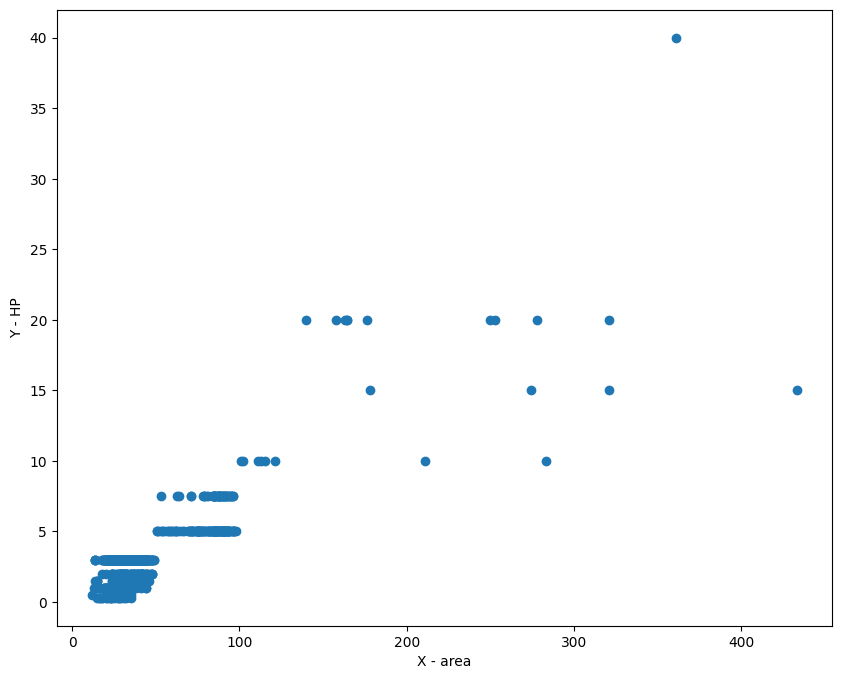

In [11]:
# diagrama de dispersion
x = area
y = hp
plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel('X - area')
plt.ylabel('Y - HP')
plt.show()

Estimacion de combinaciones para clasificacion:

Entrenamiento del modelo:

In [ ]:
x = np.array(area, dtype=int)
y = np.array(hp, dtype=float)

X=x[:,np.newaxis]
while True:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    mlr = MLPRegressor(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(3,3), random_state=1)
    mlr.fit(X_train, y_train)

    print(mlr.score(X_train, y_train))
    if mlr.score(X_train, y_train) >= 0.65: break

In [ ]:
mlr.predict(np.array([[24]]))